In [387]:
import pandas as pd
# pd.set_option("display.float_format", "{:.3f}".format)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay)
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import shap
import seaborn as sns
from IPython.display import display, Markdown, Latex
import random
random.seed(42)
import os
 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.set_seed(seed)
    random.seed

In [388]:

data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)


In [389]:
data.columns

Index(['htn_jnc7_qc', 'diabetes_status_c_qc', 'ckd_c_qc',
       'cadiovascular_current', 'bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'friedewald_ldl_c_c_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'site', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [390]:
data.shape

(4489, 25)

In [391]:
site_id = 1
data = data[(data['site'] == site_id) & (data['age'] <= 65) & (data['age'] >= 40)].copy()

In [392]:
data.loc[:,['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']].shape

(1753, 19)

In [393]:
# X = data.iloc[:,4:]
X = data[['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']]
y1 = data.loc[:,'htn_jnc7_qc']

In [394]:
data['mvpa_cat_c'].value_counts(normalize=True)

1.0    0.776954
0.0    0.223046
Name: mvpa_cat_c, dtype: float64

In [395]:
dff = data.mask(data == -999, np.nan).copy()
# dff = dff.iloc[:,4:]

[IterativeImputer] Early stopping criterion not reached.


<Axes: ylabel='Density'>

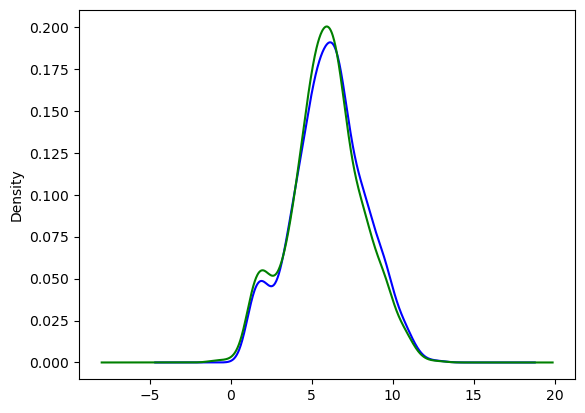

In [396]:
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer_bayes = IterativeImputer(
    estimator=BayesianRidge(),
    max_iter=10,
    random_state=42)

# let's create a MICE imputer using Bayes as estimator

imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff[X.columns])
train_t = imputer.transform(dff[X.columns])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=X.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)

fig = plt.figure()
ax = fig.add_subplot(111)
dff['visceral_fat_qc'].plot(kind='kde', ax=ax, color='blue')
treated['visceral_fat_qc'].plot(kind='kde', ax=ax, color='green')

In [397]:
# dff2 = data.mask(data == -999, np.nan)
# dff2.isnull().sum()/dff2.shape[0]


In [398]:
# X = treated.copy()
y1 = dff[['htn_jnc7_qc']]

In [399]:
treated.columns

Index(['bmi_c_qc', 'age', 'cimt_mean_max', 'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex', 'hiv_final_status_c',
       'highest_level_of_education_qc', 'partnership_status_c_qc',
       'ses_site_quintile_c_qc', 'occupation_qc', 'mvpa_cat_c',
       'alcohol_use_status_c_qc', 'smoking_status_c_qc'],
      dtype='object')

In [400]:
predictors = ['bmi_c_qc', 'age', 'cimt_mean_max',
       'cholesterol_1_qc', 'hdl_qc',
       'triglycerides_qc', 'waist_hip_r_c_qc', 'waist_circumference_qc',
       'visceral_fat_qc', 'subcutaneous_fat_qc', 'sex',
       'hiv_final_status_c', 'highest_level_of_education_qc',
       'partnership_status_c_qc', 'ses_site_quintile_c_qc', 'occupation_qc',
       'mvpa_cat_c', 'alcohol_use_status_c_qc', 'smoking_status_c_qc']

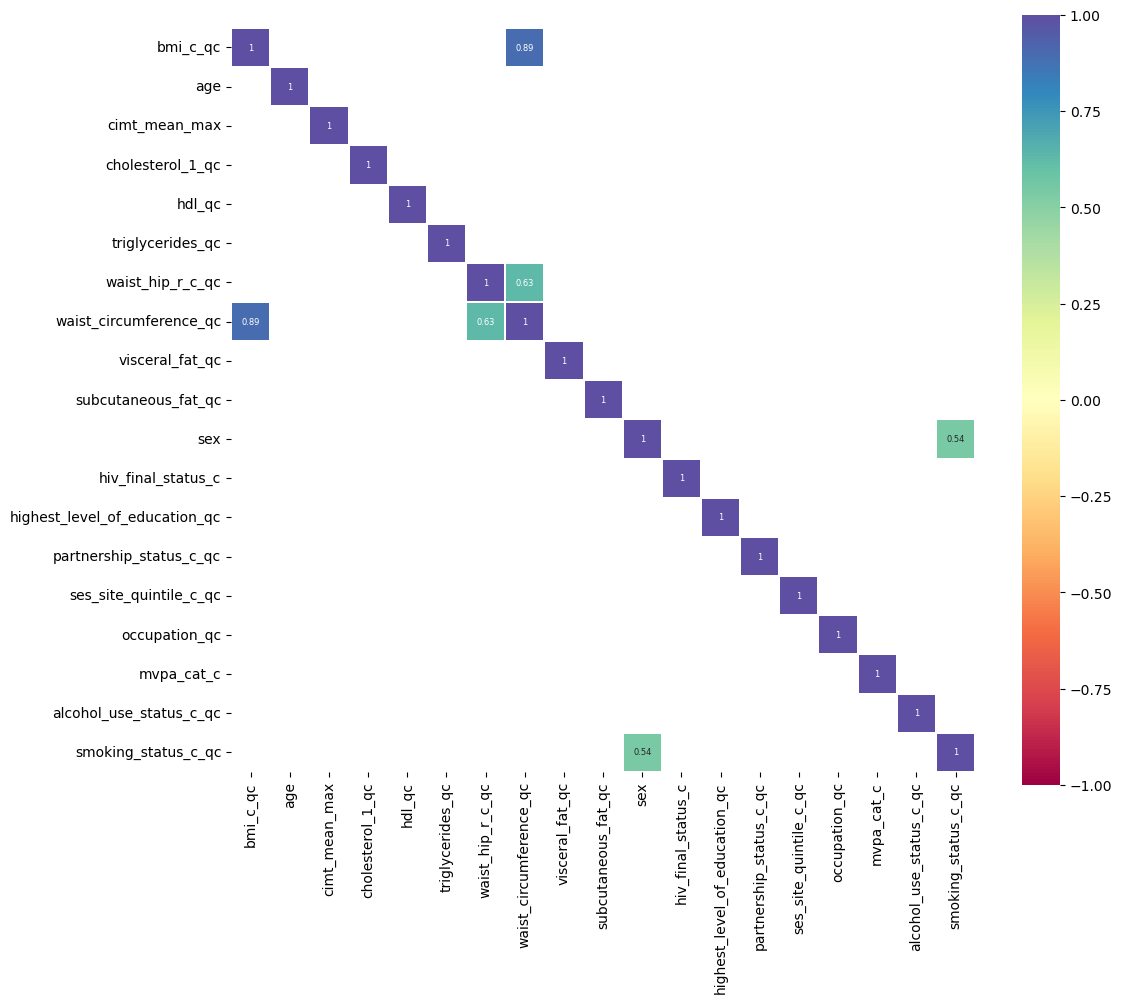

In [401]:
import seaborn as sns
import matplotlib.pyplot as plt

# Identify correlated variables using correlation coefficients
correlation_matrix = treated.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]


plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.5) | (correlation_matrix <= -0.4)], 
            cmap='Spectral', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 6}, square=True);

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


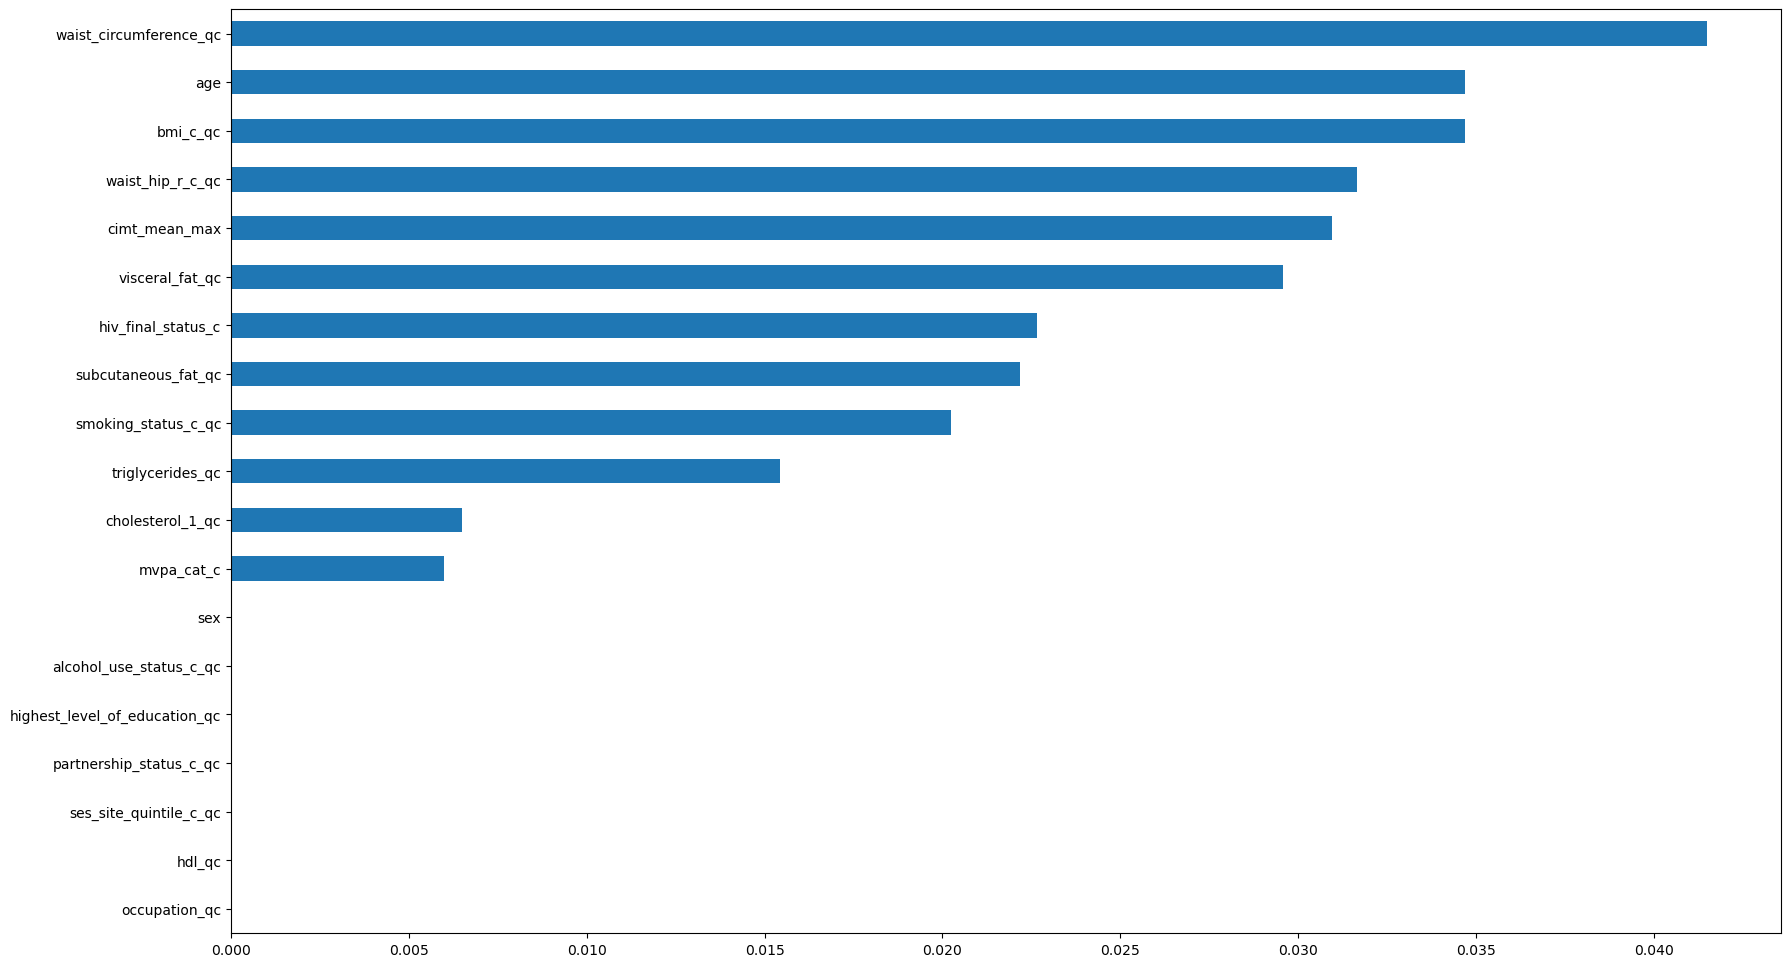

In [402]:
from sklearn.feature_selection import mutual_info_classif
## First, treat missing values before execution
# X = treated.values
X2 = treated[predictors].values
y = y1
importance = mutual_info_classif(X2,y)
# feat_importance = pd.Series(importance, treated.columns[0:len(data.columns)-1])
feat_importance = pd.Series(importance, treated[predictors].columns[0:len(treated[predictors].columns)-0])
ff = feat_importance.sort_values(ascending=True)
plt.figure(figsize=(20,12))
ff.plot(kind='barh')
plt.show()

In [403]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=treated[['sex']])

# Initialize XGBoost classifier
model = xgb.XGBClassifier()

# Define the grid of hyperparameters to search
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1]
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
model.set_params(**best_params)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
predictions = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV]

In [241]:
{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

In [404]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Load your dataset
# data = pd.read_csv('your_dataset.csv')
# X = data.drop('target_column', axis=1)
# y = data['target_column']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    # 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model using AUC
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")


Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=

`use_label_encoder` is deprecated in 1.7.0.


In [405]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

# Load your dataset
# data = pd.read_csv('your_dataset.csv')
# X = data.drop('target_column', axis=1)
# y = data['target_column']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify=treated[['sex']])

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    # 'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Initialize the XGBClassifier
xgb_clf = XGBClassifier(eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='roc_auc', cv=3, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with the best parameters
best_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model using AUC
auc_score = roc_auc_score(y_test, predictions)
print(f"The AUC score for the optimized model is: {auc_score}")


Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END learning_rate=

`use_label_encoder` is deprecated in 1.7.0.


In [24]:
best_params1 

{'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 5,
 'n_estimators': 400,
 'subsample': 0.6}

In [355]:
model1 = xgb.XGBClassifier()
model1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [361]:
xbg_pred = model.predict_proba(X_test)[:,1]
print('XGB accuracy', roc_auc_score(y_test, xbg_pred))

XGB accuracy 0.7474687705456937


In [76]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from pyswarm import pso

# Load your dataset
# data = pd.read_csv('your_dataset.csv')
# X = data.drop('target_column', axis=1)
# y = data['target_column']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Objective function to optimize
def objective_function(params):
    max_depth, learning_rate, n_estimators, subsample, min_child_weight, gamma, colsample_bytree = params

    # Ensure integer type for certain parameters
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    # Create and fit the model
    model = XGBClassifier(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                          subsample=subsample, min_child_weight=min_child_weight, gamma=gamma,
                          colsample_bytree=colsample_bytree, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    # Predict and calculate AUC
    # predictions = model.predict_proba(X_test)[:, 1]
    predictions = model.predict(X_test)
    auc = roc_auc_score(y_test, predictions)
    
    # Return negative AUC for maximization
    return -auc

# Define bounds for hyperparameters
lb = [1, 0.01, 50, 0.5, 1, 0, 0.5]  # Lower bounds
ub = [10, 0.5, 300, 1.0, 10, 5, 1.0]  # Upper bounds

# Run PSO
xopt, fopt = pso(objective_function, lb, ub, swarmsize=25, maxiter=100, debug=True)

# Best parameters found
print(f"Optimal Parameters: {xopt}")
print(f"Maximum AUC achieved: {-fopt}")


No constraints given.
New best for swarm at iteration 1: [1.00000000e+01 1.00000000e-02 2.38979582e+02 7.13383685e-01
 7.65079577e+00 5.00000000e+00 8.12276413e-01] -0.678376268540203
New best for swarm at iteration 1: [ 6.5468492   0.0848855  50.          0.65440259  4.40971646  4.51685329
  0.88811027] -0.6813524590163935
Best after iteration 1: [ 6.5468492   0.0848855  50.          0.65440259  4.40971646  4.51685329
  0.88811027] -0.6813524590163935
New best for swarm at iteration 2: [1.00000000e+01 1.00000000e-02 2.31353746e+02 6.97597700e-01
 6.20027863e+00 5.00000000e+00 7.56517426e-01] -0.6922814207650273
Best after iteration 2: [1.00000000e+01 1.00000000e-02 2.31353746e+02 6.97597700e-01
 6.20027863e+00 5.00000000e+00 7.56517426e-01] -0.6922814207650273
New best for swarm at iteration 3: [7.03573252e+00 1.00000000e-02 1.60698378e+02 6.98327562e-01
 5.97756630e+00 5.00000000e+00 9.00975667e-01] -0.6982338017174082
Best after iteration 3: [7.03573252e+00 1.00000000e-02 1.60698378

In [77]:
# max_depth, learning_rate, n_estimators, subsample, min_child_weight
xopt

array([7.68838966e+00, 1.04928524e-02, 1.68789572e+02, 7.00223874e-01,
       5.99751638e+00, 5.00000000e+00, 8.80392288e-01])

In [137]:
best_params1 = {'learning_rate': 1.04928524e-02,
 'max_depth': 7,
 'min_child_weight': 9.98668141e+00,
 'n_estimators': 168,
 'subsample': 7.00223874e-01,
#  'gamma': 5.99751638e+00,
#  'colsample_bytree': 8.80392288e-01
 }

In [365]:
best_modelpso = XGBClassifier(**best_params1, use_label_encoder=False, eval_metric='logloss')
best_modelpso.fit(X_train, y_train)

`use_label_encoder` is deprecated in 1.7.0.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0104928524,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0,
              min_child_weight=9.98668141, missing=nan,
              monotone_constraints='()', n_estimators=168, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [366]:
xbg_pred2 = best_modelpso.predict_proba(X_test)[:,1]
print('XGB accuracy', roc_auc_score(y_test, xbg_pred2))

XGB accuracy 0.7389875082182775


In [368]:
xbg_pred = model.predict_proba(X_test)[:,1]
print('XGB accuracy', roc_auc_score(y_test, xbg_pred))

XGB accuracy 0.7474687705456937


In [369]:
data = pd.read_csv('/Users/kayadetunji/Downloads/HAALSI_work/project2_data_21_04_23.csv').drop(columns = 
       ['Unnamed: 0','study_id']).fillna(-999)
site_id = 3
data1 = data[(data['site'] == site_id) & (data['age'] <= 65) & (data['age'] >= 40)].copy()
# X1 = data1.iloc[:,4:]
y2 = data1.loc[:,'htn_jnc7_qc']

In [371]:
data.htn_jnc7_qc.value_counts(normalize=True)

0    0.554244
1    0.445756
Name: htn_jnc7_qc, dtype: float64

In [372]:
X.shape

(1753, 19)

In [381]:
dff2 = data1.mask(data1 == -999, np.nan)
# dff2.isnull().sum()/dff2.shape[0]

In [382]:
imputer = IterativeImputer(
    estimator=BayesianRidge(), # the estimator to predict the NA
    initial_strategy='mean', # how will NA be imputed in step 1
    max_iter=10, # number of cycles
    imputation_order='ascending', # the order in which to impute the variables
    n_nearest_features=None, # whether to limit the number of predictors
    skip_complete=True, # whether to ignore variables without NA
    random_state=0,
)
imputer.fit(dff2[X.columns])
train_t = imputer.transform(dff2[X.columns])
# train_x = imputer.transform(data.iloc[:,2:])
treated = pd.DataFrame(train_t, columns=X.columns)
# treated = treated.apply(np.ceil)
treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']]\
      = np.round(treated.loc[:,['highest_level_of_education_qc','occupation_qc','smoking_status_c_qc']], decimals=0)


In [383]:
X = treated.iloc[:,4:]
y1 = dff2.loc[:,'htn_jnc7_qc']

In [385]:
X.shape

(1992, 11)

In [384]:

xbg_pred1 = model.predict_proba(treated)[:,1]
print('XGB accuracy', roc_auc_score(y2, xbg_pred1))

ValueError: Feature shape mismatch, expected: 19, got 15

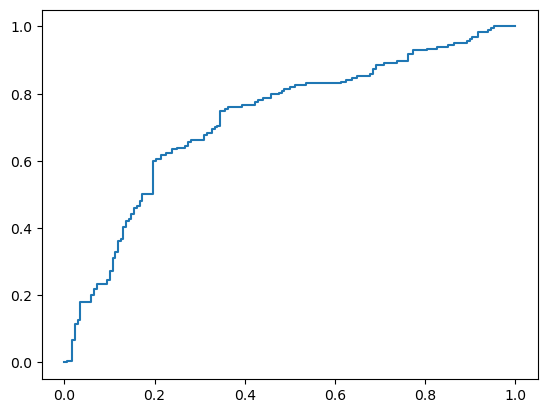

In [97]:
from sklearn import metrics
plt.figure(0).clf()

#fit logistic regression model and plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_test, xbg_pred)
auc = round(metrics.roc_auc_score(y_test, xbg_pred), 4)
plt.plot(fpr,tpr,label="XGBoost, AUC="+str(auc))

### Expalainable ML

In [295]:
# SHAP Modelling
shap.initjs()
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

In [296]:
# SHAP Analysis

explainer1 = shap.TreeExplainer(model, X_test)
shap_values1 = explainer1(X_test)

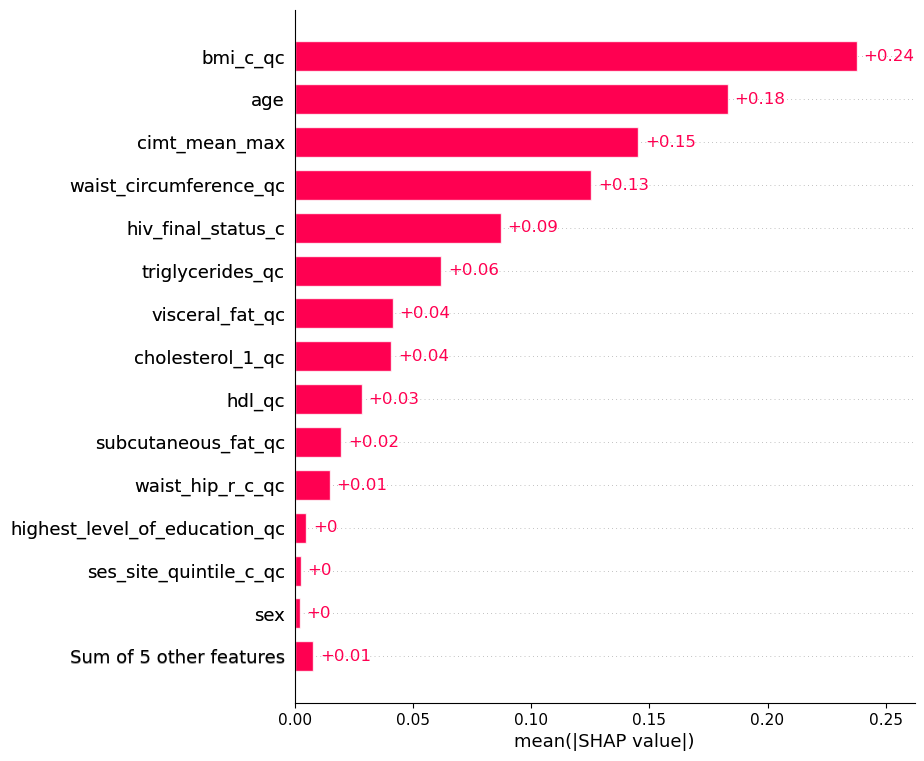

In [297]:
shap.plots.bar(shap_values, max_display=15)

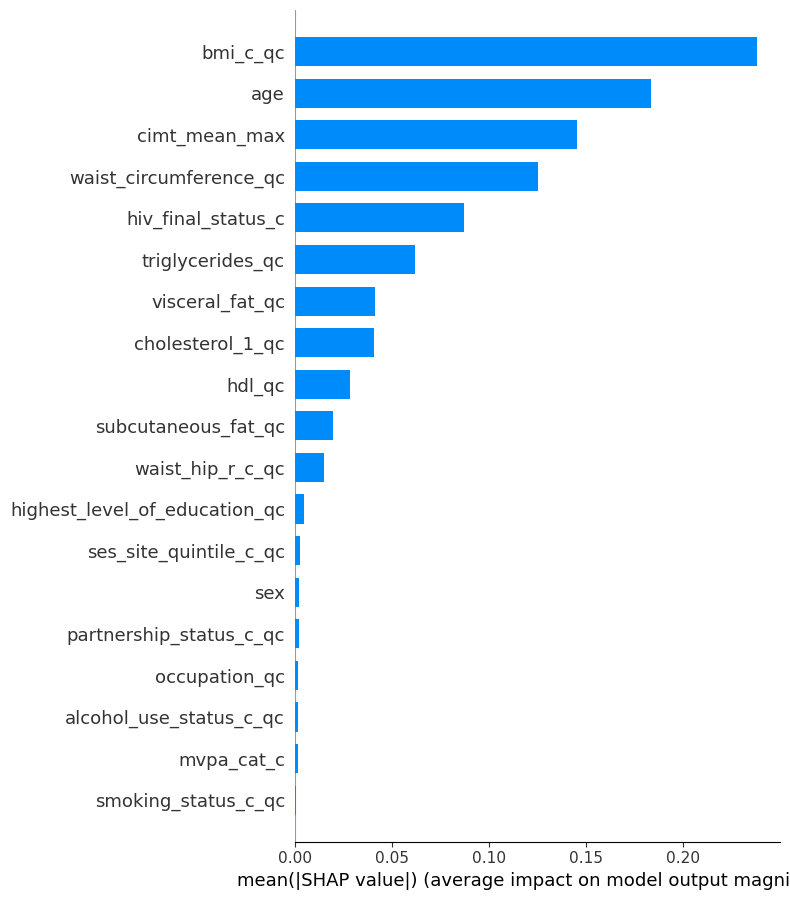

In [298]:
shap.summary_plot(shap_values, plot_type = 'bar' )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


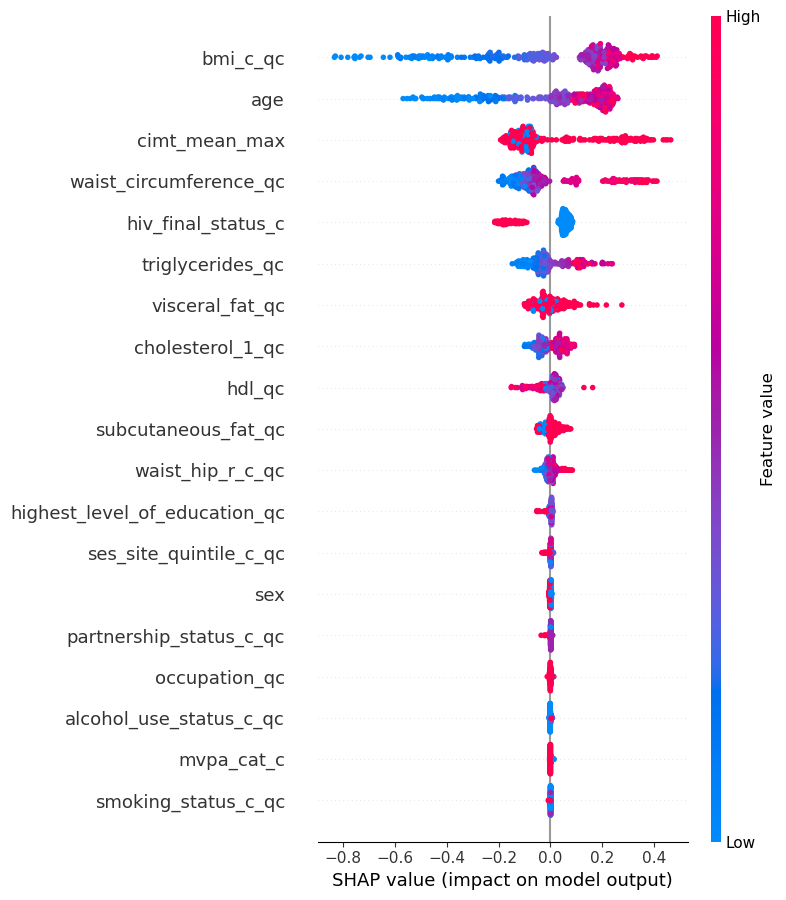

In [299]:
shap.summary_plot(shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


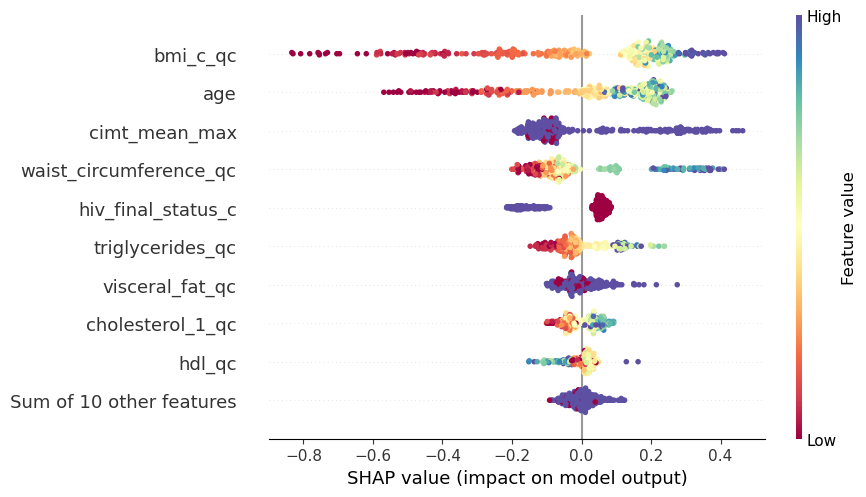

In [300]:
shap.plots.beeswarm(shap_values, color=plt.get_cmap("Spectral"))

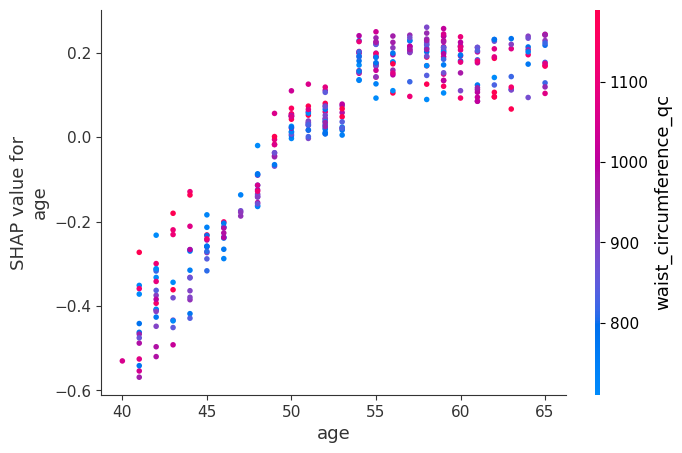

In [322]:
shap.dependence_plot("age", shap_values.values, X_test)

In [336]:
# explainer5 = shap.Explainer(model)
# shap_values5 = explainer5.shap_values(X_test)
# # shap.initjs()
def local_explainer(j):
    return(shap.force_plot(explainer.expected_value, shap_values5[j,:], X_test.iloc[j,:]))
def local_explainer_logit(j):
    return(shap.force_plot(explainer.expected_value, shap_values[j,:], X_test.iloc[j,:], link='logit'))

In [315]:
explainer5 = shap.Explainer(model)
shap_values5 = explainer5.shap_values(X_test)
# shap.initjs()
def local_explainer2(k):
    return(shap.plots.waterfall(shap_values[k]))
    # return(shap.force_plot(explainer.expected_value, shap_values5[j,:], X_test.iloc[j,:]))
def local_explainer_logit2(k):
    return(shap.plots.waterfall(shap_values[k]))
    # return(shap.force_plot(explainer.expected_value, shap_values5[j,:], X_test.iloc[j,:], link='logit'))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [333]:
y_test.head(30)

,htn_jnc7_qc
3789,0
1132,0
4400,0
3927,0
2011,0
1145,1
2910,1
2645,1
486,0
2697,0


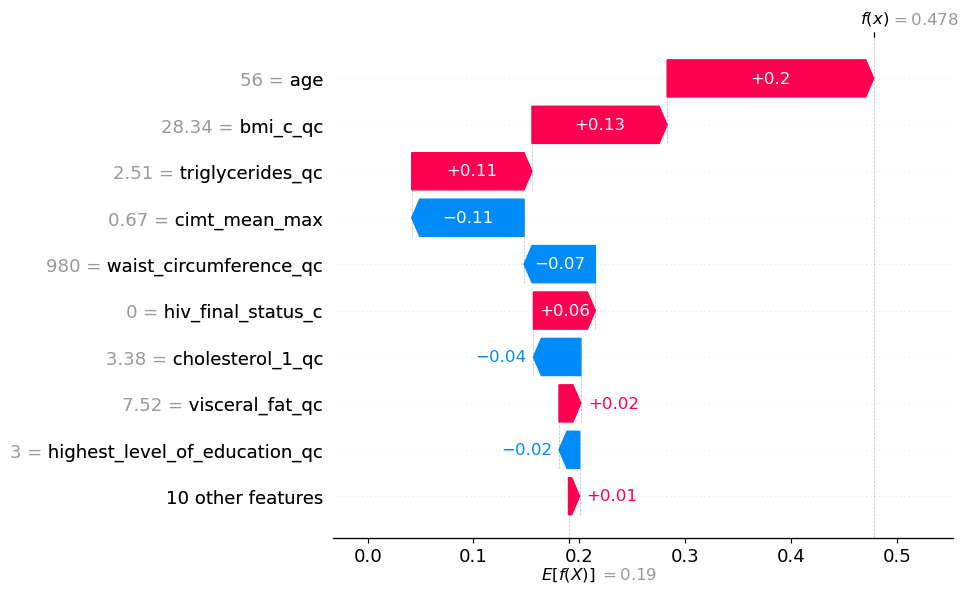

In [364]:
local_explainer_logit2(-1)

In [337]:
local_explainer_logit(5)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [314]:
local_explainer_logit(-2)